# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# see what we're working with in terms of columns for feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [37]:
# Identify missing or unknown data values and convert them to NaNs.

In [7]:
# defining the function to strip and change the values
# takes in string [-1, 0, 9], etc. spits out splits
def nan_convert(string):
    # create the empty list that will get filled and returned
    nan_list = []
    
    # strip the bracket characters and split into a python list
    split_string = string.strip('[]').split(',')
    
    for i in split_string:
        # check if it's numerical before trying to int
        # have to see if removing negative sign leaves i numeric, it breaks otherwise
        if i.isnumeric() or i.strip('-').isnumeric():
            # append the integer-ized i to our nan_list
            nan_list.append(int(i))
            
        # if it isn't numeric we can just append it as-is
        else:
            nan_list.append(i)
    
    return nan_list

In [8]:
# getting the list of values indicating missing or unknown
# using .apply with lambda to turn to individual values
feat_info.iloc[:,3] = feat_info.iloc[:,3].apply(nan_convert)

In [9]:
# checking if things have changed in feat_info the way we want
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
# create a list of the attributes (azdias column titles)
attributes = feat_info['attribute'].values

for i in range(len(feat_info['missing_or_unknown'])):
    column = attributes[i]
    azdias[column].replace(to_replace=feat_info['missing_or_unknown'][i],
                           value=np.NaN,
                           inplace=True)

In [11]:
# check if it worked
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [110]:
# create a backup of azdias in case things go wrong during testing later

In [12]:
azdias_backup = azdias
azdias_backup.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# this can be done with .isnull().sum(). resetting index to get labels
miss_columns = azdias.isnull().sum().reset_index()
miss_columns.rename(columns={'index': 'attrib', 0: 'num_na'}, inplace=True)
miss_columns.head()

,attrib,num_na
0,AGER_TYP,685843
1,ALTERSKATEGORIE_GROB,2881
2,ANREDE_KZ,0
3,CJT_GESAMTTYP,4854
4,FINANZ_MINIMALIST,0


Text(0.5,1,'Missing data in columns')

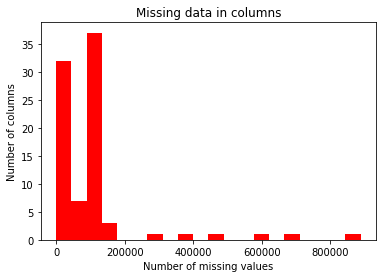

In [14]:
# Investigate patterns in the amount of missing data in each column.
# using a hist to do this
plt.hist(miss_columns['num_na'], bins=20, color='r')
plt.xlabel('Number of missing values')
plt.ylabel('Number of columns')
plt.title('Missing data in columns')

From the hist above, we can see that most of our data is in the <200000 range in terms of how much data is missing, so I'm saying that anything above that 200000 number is an outlier

In [15]:
# check to see the ones >200000
print(miss_columns[miss_columns['num_na']>200000])

          attrib  num_na
0       AGER_TYP  685843
11   GEBURTSJAHR  392318
40      TITEL_KZ  889061
43      ALTER_HH  310267
47  KK_KUNDENTYP  584612
64  KBA05_BAUMAX  476524


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_columns = miss_columns[miss_columns['num_na']>200000]

# drop the designated outlier columns
azdias.drop(labels=drop_columns['attrib'], inplace=True, axis=1)

In [17]:
# check azdias to make sure they dropped
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Since we have 6 columns missing now, we know the 6 columns were dropped correctly.

#### Discussion 1.1.2: Assess Missing Data in Each Column

Given that most of our data fell in the <=200000 missing/unknown entries range, only 6 columns were dropped.  Many of the columns were missing at least some data (more were missing data than not).  The columns that have been dropped for having too many missing/unknown entries are the following 6:

        AGER_TYP  685843
     GEBURTSJAHR  392318
        TITEL_KZ  889061
        ALTER_HH  310267
    KK_KUNDENTYP  584612
    KBA05_BAUMAX  476524
    
The following columns have the same amount of missing data suggesting that they may be able to be pared down with minimal impact on our results, most are simply changes in scale for the same question, so this makes sense:

- LP_FAMILIE_FEIN // LP_FAMILIE_GROB = 77792 (Family type, fine scale and rough scale)
- LP_STATUS_FEIN // LP_STATUS_GROB = 4854  (Social status, fine scale and rough scale)
- OST_WEST_KZ // WOHNLAGE = 93148        (Building location via former East / West Germany, neighborhood quality/rural)
- CAMEO_DEUG_2015 // CAMEO_DEU_2015 // CAMEO_INTL_2015 = 99352 (German CAMEO: Wealth / Life Stage Typology, various)
- KBA05_ANTG1 // ... // KBA05_ANTG4 = 133324 (number of houses of various types in microcell)
- PLZ8_ANTG1 // ... // PLZ8_GBZ = 116515 (number of houses withing PLZ8 region)

Some columns were missing no data:

- FINANZ_MINIMALIST	// ... // FINANZTYP (Financial topology)
- SEMIO_SOZ // ... // SEMIO_TRADV (Personality topology)
- GREEN_AVANTGARDE ("Membership in environmental sustainability as part of youth")

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?

miss_rows = azdias.isnull().sum(axis=1).reset_index()
miss_rows.drop(columns='index', inplace=True)
miss_rows.rename(columns={0: 'num_na'}, inplace=True)
miss_rows.head()

,num_na
0,43
1,0
2,0
3,7
4,0


Text(0.5,1,'Missing data in rows')

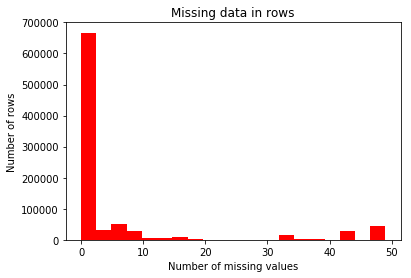

In [19]:
# plotting with hist like before to see the distribution
plt.hist(miss_rows['num_na'], bins=20, color='r')
plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')
plt.title('Missing data in rows')

It's clear from this histogram that we have two distinct subsets of data: ~<=20 and ~>=30.  I'll split at 25 to split the difference here.

In [20]:
# creating a new azdias with the missing rows for the sake of splitting easily
azdias_rows = azdias.join(miss_rows)
azdias_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,num_na
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_split_sub25 = azdias_rows[azdias_rows['num_na'] <25]

azdias_split_above25 = azdias_rows[azdias_rows['num_na'] >=25]

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_columns(split1, split2, column_list):
    for col in column_list:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        plt.subplots_adjust(wspace=1)
        sns.countplot(split1[col], ax=ax1)
        sns.countplot(split2[col], ax=ax2)
        fig.show()

In [23]:
column_list = ['FINANZ_MINIMALIST',
               'FINANZTYP',
               'SEMIO_SOZ',
               'ANREDE_KZ',
               'GREEN_AVANTGARDE']

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


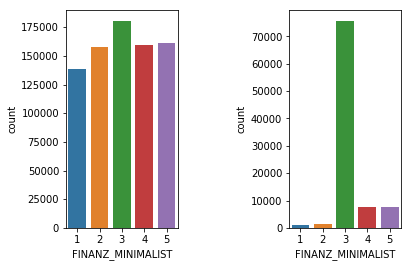

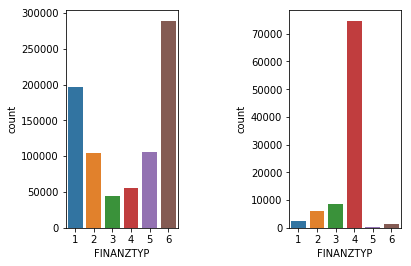

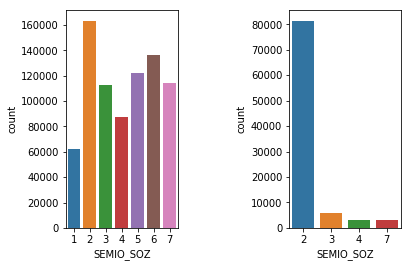

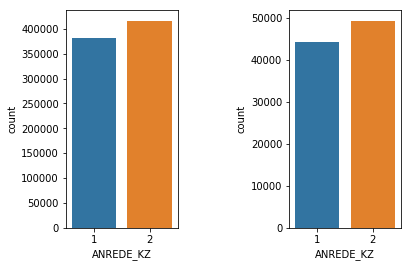

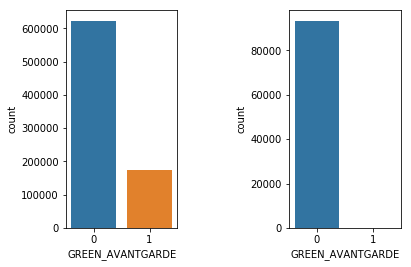

In [24]:
compare_columns(azdias_split_sub25,
                azdias_split_above25,
                column_list)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Looking at the output above it seems clear that rows of data with high numbers of missing data (na>=25) tend to be heavily skewed in the answers that we looked at.  This would suggest, to me, that the data is certainly qualitatively different than the data that is missing less (na<20), which generally seems to be a little more evenly distributed.  At the very least it suggests that perhaps many of the rows missing more information tended to have a much more focused answer as a set.  I think that removing these rows with higher NaN counts will be beneficial to the project.

In [25]:
azdias_new = azdias_split_sub25
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,num_na
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
feat_type_counts = feat_info.type.value_counts()
print(feat_type_counts)

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_vars = feat_info[feat_info['type'] == 'categorical']['attribute']
categorical_vars = categorical_vars.values
print(categorical_vars)

['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.

bin_cats = []
multi_cats = []

for column in azdias_new:
    if column in categorical_vars:
        val = azdias_new[column].nunique()
        if val == 2:
            bin_cats.append(column)
        else:
            multi_cats.append(column)

print(bin_cats)
print(multi_cats)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [29]:
azdias_new[bin_cats].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


OST_WEST_KZ is non-numeric, so we'll re-encode the values.

In [30]:
azdias_new.OST_WEST_KZ = azdias_new.OST_WEST_KZ.replace({'W':0, 'O':1})
azdias_new[bin_cats].head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,0
2,2,1,0.0,1.0,0
3,2,0,0.0,1.0,0
4,1,0,0.0,2.0,0
5,2,0,0.0,2.0,0


Now one-hot-encoding for the multi_cats

In [31]:
azdias_new = pd.get_dummies(azdias_new, columns = multi_cats)

In [32]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I kept all of the features and didn't drop any.  Binary features that were numeric (ANREDE_KZ, GREEN_AVANTGARDE, etc.) I left them as-is since they will already work nicely.  For the binary feature that used non-numeric options (OST_WEST_KZ) I used .replace to change the 'W' to 0 and the 'O' to 1.  For the multi categories I used one-hot-encoding (pd.get_dummies) to create binary options for each of the possible category results.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
mixed_vars = feat_info[feat_info['type'] == 'mixed']['attribute']
mixed_vars = mixed_vars.values
print(mixed_vars)

['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'KBA05_BAUMAX' 'PLZ8_BAUMAX']


In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

On its own this info isn't helpful, so I decided to paste the data dictionary's entry here for comparison:
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Based on the dictionary above, it looks like we'll want to split out both the decade and whether the dominating movement was mainstream(0) or avantgarde(1).  I'll do this using dictionaries and the .replace() feature like I used for OST_WEST_KZ.

New variables will be PRAEGENDE_JUGENDJAHRE_DEC and PRAEGENDE_JUGENDJAHRE_MVMT, placeholders copied from PRAEGENDE_JUGENDJAHRE

In [35]:
azdias_new['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias_new['PRAEGENDE_JUGENDJAHRE']
azdias_new['PRAEGENDE_JUGENDJAHRE_MVMT'] = azdias_new['PRAEGENDE_JUGENDJAHRE']

In [36]:
# create our mapping dictionaries
decade = {1: 40,
          2: 40,
          3: 50,
          4: 50,
          5: 60,
          6: 60,
          7: 60,
          8: 70,
          9: 70,
          10: 80,
          11: 80,
          12: 80,
          13: 80,
          14: 90,
          15: 90}

movement = {1: 0,
            2: 1,
            3: 0,
            4: 1,
            5: 0,
            6: 1,
            7: 1,
            8: 0,
            9: 1,
            10: 0,
            11: 1,
            12: 0,
            13: 1,
            14: 0, 
            15: 1}

In [37]:
# use the dictionaries to set our new value mapping
azdias_new.PRAEGENDE_JUGENDJAHRE_DEC = azdias_new.PRAEGENDE_JUGENDJAHRE_DEC.replace(decade)
azdias_new.PRAEGENDE_JUGENDJAHRE_MVMT = azdias_new.PRAEGENDE_JUGENDJAHRE_MVMT.replace(movement)

In [38]:
# double-check
azdias_new['PRAEGENDE_JUGENDJAHRE_DEC'].head()

1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: PRAEGENDE_JUGENDJAHRE_DEC, dtype: float64

In [39]:
# double-check
azdias_new['PRAEGENDE_JUGENDJAHRE_MVMT'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: PRAEGENDE_JUGENDJAHRE_MVMT, dtype: float64

# Investigate "CAMEO_INTL_2015" and engineer two new variables.

I've decided to skip straight ahead to using the data dictionary this time, that's way more useful.

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

Based on the dictionary above, it looks like we'll want to split out both the wealth level (Wealthy, Prosperous, etc.: 1-5, respectively) and the life stage(Pre-Family, Young Couples with Children, etc.: 1-5, respectively).  I'll do this using dictionaries and the .replace() feature as above

New variables will be CAMEO_INTL_2015_WLTH (wealth) and CAMEO_INTL_2015_LS (life stage), placeholders copied from CAMEO_INTL_2015

In [40]:
# Create the new columns
azdias_new['CAMEO_INTL_2015_WLTH'] = azdias_new['CAMEO_INTL_2015']
azdias_new['CAMEO_INTL_2015_LS'] = azdias_new['CAMEO_INTL_2015']

In [41]:
# create the dictionaries
wealth = {'11': 1,
          '12': 1,
          '13': 1,
          '14': 1,
          '15': 1,
          '21': 2,
          '22': 2,
          '23': 2,
          '24': 2,
          '25': 2,
          '31': 3,
          '32': 3,
          '33': 3,
          '34': 3, 
          '35': 3,
          '41': 4,
          '42': 4,
          '43': 4,
          '44': 4, 
          '45': 4,
          '51': 5,
          '52': 5,
          '53': 5,
          '54': 5, 
          '55': 5}

stage = {'11': 1,
         '12': 2,
         '13': 3,
         '14': 4,
         '15': 5,
         '21': 1,
         '22': 2,
         '23': 3,
         '24': 4,
         '25': 5,
         '31': 1,
         '32': 2,
         '33': 3,
         '34': 4, 
         '35': 5,
         '41': 1,
         '42': 2,
         '43': 3,
         '44': 4, 
         '45': 5,
         '51': 1,
         '52': 2,
         '53': 3,
         '54': 4, 
         '55': 5}

In [42]:
# use the dictionaries to replace the values
azdias_new.CAMEO_INTL_2015_WLTH = azdias_new.CAMEO_INTL_2015_WLTH.replace(wealth)
azdias_new.CAMEO_INTL_2015_LS = azdias_new.CAMEO_INTL_2015_LS.replace(stage)

In [43]:
# double check
azdias_new['CAMEO_INTL_2015_WLTH'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WLTH, dtype: float64

In [44]:
azdias_new['CAMEO_INTL_2015_LS'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_LS, dtype: float64

In [45]:
# dropping the originals for both of the above
azdias_new.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)

In [46]:
# dropping the additional mixed variables
azdias_new.drop(['LP_LEBENSPHASE_FEIN',
                 'LP_LEBENSPHASE_GROB',
                 'WOHNLAGE',
                 'PLZ8_BAUMAX'],
                 axis=1,
                 inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I split both of the listed columns into two variables each (PRAEGENDE_JUGENDJAHRE_DEC and PRAEGENDE_JUGENDJAHRE_MVMT) and (CAMEO_INTL_2015_WLTH (wealth) and CAMEO_INTL_2015_LS (life stage)) {both explained above}.  I've also dropped the remaining mixed variables since many of them seem to overlap with other columns based on their explanations in the data dictionary.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# finished

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')
    feat_info.iloc[:,3] = feat_info.iloc[:,3].apply(nan_convert)
    
    attributes = feat_info['attribute'].values

    for i in range(len(feat_info['missing_or_unknown'])):
        column = attributes[i]
        df[column].replace(to_replace=feat_info['missing_or_unknown'][i],
                               value=np.NaN,
                               inplace=True)
    
    # columns
    miss_columns = df.isnull().sum().reset_index()
    miss_columns.rename(columns={'index': 'attrib', 0: 'num_na'}, inplace=True)
    drop_columns = miss_columns[miss_columns['num_na']>200000]

    # drop the designated outlier columns
    df.drop(labels=drop_columns['attrib'], inplace=True, axis=1)
    
    # now the rows
    miss_rows = df.isnull().sum(axis=1).reset_index()
    miss_rows.drop(columns='index', inplace=True)
    miss_rows.rename(columns={0: 'num_na'}, inplace=True)
    df_rows = df.join(miss_rows)
    df_split_sub25 = df_rows[azdias_rows['num_na'] <25]
    
    df_new = df_split_sub25
    
    
    # select, re-encode, and engineer column values.
    categorical_vars = feat_info[feat_info['type'] == 'categorical']['attribute']
    categorical_vars = categorical_vars.values
    
    bin_cats = []
    multi_cats = []

    for column in df_new:
        if column in categorical_vars:
            val = df_new[column].nunique()
            if val == 2:
                bin_cats.append(column)
            else:
                multi_cats.append(column)
    
    # fix OST_WEST_KZ
    df_new.OST_WEST_KZ = df_new.OST_WEST_KZ.replace({'W':0, 'O':1})
    
    # one hot encoding
    df_new = pd.get_dummies(df_new, columns = multi_cats)
    
    # re-encoding the two selected mixed-vars
    df_new['PRAEGENDE_JUGENDJAHRE_DEC'] = df_new['PRAEGENDE_JUGENDJAHRE']
    df_new['PRAEGENDE_JUGENDJAHRE_MVMT'] = df_new['PRAEGENDE_JUGENDJAHRE']
    
    decade = {1: 40,
              2: 40,
              3: 50,
              4: 50,
              5: 60,
              6: 60,
              7: 60,
              8: 70,
              9: 70,
              10: 80,
              11: 80,
              12: 80,
              13: 80,
              14: 90,
              15: 90}

    movement = {1: 0,
                2: 1,
                3: 0,
                4: 1,
                5: 0,
                6: 1,
                7: 1,
                8: 0,
                9: 1,
                10: 0,
                11: 1,
                12: 0,
                13: 1,
                14: 0, 
                15: 1}
    
    df_new.PRAEGENDE_JUGENDJAHRE_DEC = df_new.PRAEGENDE_JUGENDJAHRE_DEC.replace(decade)
    df_new.PRAEGENDE_JUGENDJAHRE_MVMT = df_new.PRAEGENDE_JUGENDJAHRE_MVMT.replace(movement)
    
    df_new['CAMEO_INTL_2015_WLTH'] = df_new['CAMEO_INTL_2015']
    df_new['CAMEO_INTL_2015_LS'] = df_new['CAMEO_INTL_2015']
    
    wealth = {'11': 1,
              '12': 1,
              '13': 1,
              '14': 1,
              '15': 1,
              '21': 2,
              '22': 2,
              '23': 2,
              '24': 2,
              '25': 2,
              '31': 3,
              '32': 3,
              '33': 3,
              '34': 3, 
              '35': 3,
              '41': 4,
              '42': 4,
              '43': 4,
              '44': 4, 
              '45': 4,
              '51': 5,
              '52': 5,
              '53': 5,
              '54': 5, 
              '55': 5}

    stage = {'11': 1,
             '12': 2,
             '13': 3,
             '14': 4,
             '15': 5,
             '21': 1,
             '22': 2,
             '23': 3,
             '24': 4,
             '25': 5,
             '31': 1,
             '32': 2,
             '33': 3,
             '34': 4, 
             '35': 5,
             '41': 1,
             '42': 2,
             '43': 3,
             '44': 4, 
             '45': 5,
             '51': 1,
             '52': 2,
             '53': 3,
             '54': 4, 
             '55': 5}
    
    df_new.CAMEO_INTL_2015_WLTH = df_new.CAMEO_INTL_2015_WLTH.replace(wealth)
    df_new.CAMEO_INTL_2015_LS = df_new.CAMEO_INTL_2015_LS.replace(stage)
    
    # drop the old ones that have been re-encoded
    df_new.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)
    
    # dropping the additional mixed variables
    df_new.drop(['LP_LEBENSPHASE_FEIN',
                 'LP_LEBENSPHASE_GROB',
                 'WOHNLAGE',
                 'PLZ8_BAUMAX'],
                 axis=1,
                 inplace=True)
    

    # Return the cleaned dataframe.
    return df_new

In [48]:
# testing it
test_az = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [49]:
test_df = clean_data(test_az)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [54]:
# do they match?
azdias_new.shape == test_df.shape

True

It works!

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [206]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# using imputer to be safe
my_imputer = Imputer(missing_values='NaN', strategy='median')
azdias_step2 = my_imputer.fit_transform(azdias_new)

In [207]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_step2 = scaler.fit_transform(azdias_step2)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I chose to replace the NaN values in the data with the median as taken by sklearn's median strategy to replace all NaNs with the median value of the axis.  I then created a scaler from StandardScaler() to scale all of the features to mean 1, std 0 to improve the use of things like PCA and KMeans down the line.  I felt that dropping all rows with NaNs would limit the dataset far too much due to the sheer number of rows with at least a single NaN value.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# wanted to look at the shape to try to decide on a PCA number
azdias_step2.shape

(797906, 193)

In [53]:
# Apply PCA to the data.
pca = PCA(50)
X_pca = pca.fit_transform(azdias_step2)

In [55]:
# Investigate the variance accounted for by each principal component.
# re-using the scree_plot function from the helper functions in the class
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



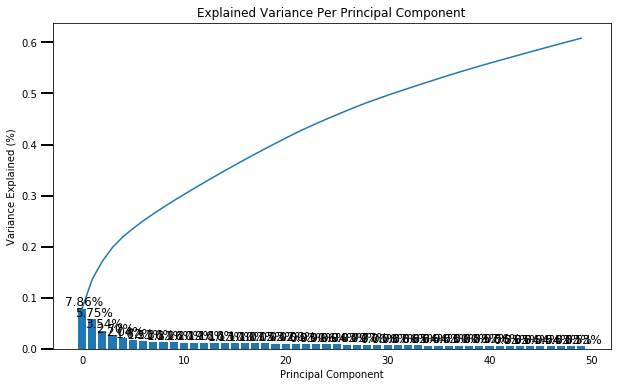

In [56]:
scree_plot(pca)

In [57]:
pca.explained_variance_ratio_.sum()

0.60831260300229006

In [58]:
# shooting for 85% of variance explained like in the lesson
comp = [50, 60, 70, 80, 100]
for num in comp:
    pca = PCA(num)
    X_pca = pca.fit_transform(azdias_step2)
    num_comps = num
    if pca.explained_variance_ratio_.sum() >= .85:
        break

print(num_comps)
print(pca.explained_variance_ratio_.sum())

100
0.871725944664


In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(100)
X_pca = pca.fit_transform(azdias_step2)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Based on my analysis I found that ~61% of the variance was explained by the top 50 principal components.  I wanted to reach for a higher number; since the lesson shot for >=85% I decided to do the same.  After testing a few sets of numbers, I found that 100 principal components explained 87% of variance, so I settled on 100 as my number.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

check_comps = pd.DataFrame(pca.components_)
check_comps.columns = azdias_new.columns
print(check_comps)

    ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              -0.084694   0.014789          -0.192419       0.115855   
1               0.232847   0.039249           0.086561      -0.226540   
2               0.014869  -0.344923           0.128609      -0.055426   
3              -0.024332   0.086185          -0.003836       0.009991   
4               0.049869  -0.026448           0.049115      -0.027015   
5               0.007627  -0.001235           0.133737      -0.013833   
6               0.028695   0.004853           0.025888      -0.016017   
7               0.029366  -0.020320           0.006350      -0.030125   
8              -0.046038   0.019348           0.031213      -0.004800   
9              -0.020273   0.021688          -0.070366       0.019517   
10              0.070725  -0.038586          -0.073233       0.027152   
11              0.013002  -0.013550          -0.006661      -0.003131   
12             -0.004981  -0.030162           0.012

In [61]:
def show_princ_comps(df, comp_num):
    # sort the values to make sure we're getting the proper principal comp first
    df = df.sort_values(df.index[comp_num], axis=1)
    
    return df.iloc[[comp_num]]

In [62]:
# looking it up showed that display would probably be a better way to show this
display(show_princ_comps(check_comps, 0))

,MOBI_REGIO,FINANZ_MINIMALIST,KBA05_ANTG1,PLZ8_ANTG1,KBA05_GBZ,KONSUMNAEHE,PLZ8_GBZ,INNENSTADT,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_5.0,...,LP_STATUS_FEIN_1.0,KBA05_ANTG4,FINANZ_HAUSBAUER,EWDICHTE,ORTSGR_KLS9,PLZ8_ANTG4,PLZ8_ANTG3,CAMEO_INTL_2015_WLTH,HH_EINKOMMEN_SCORE,LP_STATUS_GROB_1.0
0,-0.205568,-0.192419,-0.189337,-0.182852,-0.181448,-0.13681,-0.133281,-0.127608,-0.115192,-0.115192,...,0.127794,0.130337,0.149693,0.15367,0.154965,0.175894,0.181768,0.186329,0.186807,0.196829


In [63]:
# it was definitely better

In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(show_princ_comps(check_comps, 1))

,PRAEGENDE_JUGENDJAHRE_DEC,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,SEMIO_REL,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KULT,ONLINE_AFFINITAET,...,LP_STATUS_FEIN_1.0,FINANZTYP_5,CJT_GESAMTTYP_2.0,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,ZABEOTYP_3,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
1,-0.238066,-0.22654,-0.215595,-0.213692,-0.20787,-0.204735,-0.203281,-0.168182,-0.16425,-0.162705,...,0.097322,0.098068,0.108264,0.128215,0.155626,0.163855,0.179954,0.20018,0.218942,0.232847


In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(show_princ_comps(check_comps, 2))

,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,SEMIO_RAT,FINANZ_ANLEGER,FINANZTYP_1,SHOPPER_TYP_2.0,LP_STATUS_FEIN_2.0,...,SEMIO_MAT,SEMIO_REL,ZABEOTYP_1,SHOPPER_TYP_0.0,FINANZ_MINIMALIST,FINANZTYP_5,SEMIO_KULT,SEMIO_SOZ,SEMIO_FAM,SEMIO_VERT
2,-0.344923,-0.315153,-0.283307,-0.26731,-0.208472,-0.154238,-0.152934,-0.100218,-0.092259,-0.079276,...,0.089086,0.113065,0.116738,0.123273,0.128609,0.134872,0.251976,0.257394,0.260446,0.318534


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For the first principal component, it seems that the most prominent negative features are MOBI-REGIO (-0.205568 movement patterns), FINANZ_MINIMALIST (-0.192419 low financial interest), KBA05_ANTG1 (-0.192419 1-2 family houses in microcell), PLZ8_ANTG1 (1-2 family houses in PLZ8 Region), etc. The most prominent positive features are LP_STATUS_GROB_1.0 (0.196829 Social Status), HH_EINKOMMEN_SCORE (0.186807 household net income), and CAMEO_INTL_2015_WLTH (0.186329 our engineered measure of wealth).  From this information we can determine that the first principal component is largely based around finances, setting up a juxtaposition between higher income/larger homes/social status and low financial interest/high movement patterns, etc.

The second principal component shows prominent negative features in PRAEGENDE_JUGENDJAHRE_DEC (-0.238066, our engineered measure of the decade of a person's youth), FINANZ_SPARER (-0.2265, money-saver), FINANZ_UNAUFFAELLIGER (-0.215595, finance inconspicuous). The most prominent positive features are ALTERSKATEGORIE_GROB (0.232847 estimated age), FINANZ_VORSORGER (0.218942, financially prepared), and ZABEOTYP_3 (0.20018, energy consumption fair supplied).  From this information we can determine that the second principal component is largely based around personality factors linking age and financial type (spending vs. saving, etc.) as well as energy conservation concern.

The third principal component shows prominent negative features in ANREDE_KZ (-0.344922, gender), SEMIO_KAEM (-0.315153 combative attitude), and SEMIO_DOM	(-0.283308 dominant minded).  The most prominent positive features are SEMIO_VERT (0.318534, dreamful), SEMIO_FAM (0.260446, family-minded), and SEMIO_SOZ (socially-minded).  From this information we can determine that the this principal component is similar to the second in that it is largely based around personality factors including gender, combativeness, and dominant-mindedness and dreamfulness, family, and social mindedness.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
# I decided to loop this similarly to how we did so in the lesson
def kmeans_score(data, center):
    
    kmeans = KMeans(center)
    model = kmeans.fit(data)
    return np.abs(model.score(data))

Text(0.5,1,'Score to K')

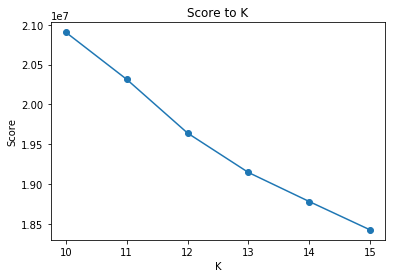

In [269]:
# run it multiple times
scores = []
centers = list(range(10, 16))

for center in centers:
    scores.append(kmeans_score(X_pca, center))

plt.plot(centers, scores, marker='o')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Score to K')

In [67]:
# Re-fit the k-means model with the selected number of clusters 

kmeans = KMeans(14)
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [68]:
# cluster predictions for the general population demographics data
gen_pop_preds = kmeans.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I decided to test the kmeans with centers ranging from 10-15.  As more centers were added the average distance from the data points to the nearest center dropped (as was expected) but it seems like the elbow (the section where the dropping is significantly slowed for k+1) was at 14, so that's the number I decided to stick with.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [69]:
# Load in the customer demographics data and check it
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [117]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_new = clean_data(customers)
customers_new.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LS
1,4.0,1,5,1,5,1,3,2,NaN,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,4.0,2,5,1,5,1,4,4,NaN,1,...,0,0,0,0,0,0,50.0,1.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,NaN,0,...,0,0,0,0,0,0,40.0,0.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,1960.0,0,...,0,0,0,0,0,0,70.0,0.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,NaN,1,...,0,0,0,0,0,0,50.0,1.0,3.0,4.0


The customer data seems to be missing a column after dropping eroneous columns.

In [121]:
for col in azdias_new.columns:
    if col not in customers_new.columns:
        print(col)

GEBAEUDETYP_5.0


It looks like there were no "GEBAEUDETYP" entries with a value of 5 in the data, so it got skipped.  It's being added below to keep things uniform.

In [122]:
customers_new.columns.get_loc('GEBAEUDETYP_4.0')

132

In [123]:
customers_new.columns.get_loc('GEBAEUDETYP_6.0')

133

In [124]:
customers_new.insert(loc = 133, column = 'GEBAEUDETYP_5.0', value = 0)

In [125]:
for col in azdias_new.columns:
    if col not in customers_new.columns:
        print(col)

In [126]:
customers_new.shape[1] == azdias_new.shape[1]

True

Now that that's settled, we can move forward with standardizing and PCA

In [208]:
# edited to remove the new calls to the scaler and to change from fit_transform
# to just transform as indicated in the review.

# imputer to fill NaNs with medians
customers_step2 = my_imputer.transform(customers_new)

# standardize with standard scaler
customers_step2 = scaler.transform(customers_step2)

In [209]:
X_pca_customers = pca.transform(customers_step2)

In [210]:
customer_preds = kmeans.predict(X_pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [211]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customer_preds_df = pd.DataFrame(customer_preds, columns=['customer_preds'])
gen_pop_preds_df = pd.DataFrame(gen_pop_preds, columns=['gen_pop_preds'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a2d5f2438>]], dtype=object)

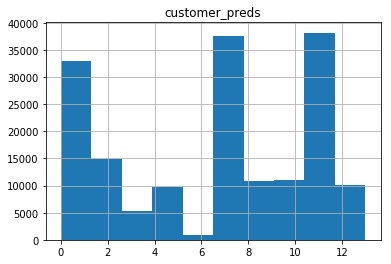

In [212]:
customer_preds_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a2d570f98>]], dtype=object)

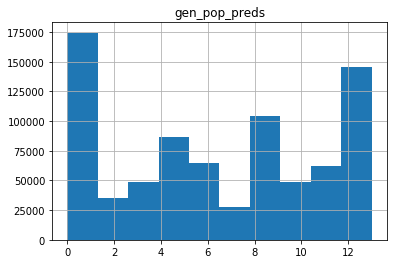

In [213]:
gen_pop_preds_df.hist()

In [214]:
# getting the proportions by dividing our pred values by the sum to get numbers rather than images
customer_proportion = pd.DataFrame(customer_preds_df['customer_preds'].value_counts()/ \
                        sum(customer_preds_df['customer_preds'].value_counts()))
gen_pop_proportion = pd.DataFrame(gen_pop_preds_df['gen_pop_preds'].value_counts()/ \
                        sum(gen_pop_preds_df['gen_pop_preds'].value_counts()))

In [215]:
display(customer_proportion)

,customer_preds
11,0.222508
7,0.219470
0,0.145310
2,0.086745
10,0.063878
9,0.056920
5,0.050785
12,0.049840
1,0.046872
3,0.030980


In [216]:
display(gen_pop_proportion)

,gen_pop_preds
0,0.118528
13,0.112750
1,0.100148
5,0.097063
6,0.080634
11,0.077998
8,0.069644
12,0.069592
9,0.061183
3,0.061045


In [217]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customers_clusters = pd.DataFrame(customer_preds, columns=['clusters'])
customers_clusters.head()

,clusters
0,12
1,11
2,0
3,1
4,2


In [218]:
cust_11_idx = customers_clusters[customers_clusters['clusters']==11]
idx = cust_11_idx.index
cust_11_idx.head()

,clusters
1,11
5,11
6,11
12,11
13,11


In [219]:
cust_11_df = customers_new.loc[idx, :]
cust_11_df.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LS
1,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,3.0,4.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,2.0,3.0
12,4.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,2.0,2.0
13,3.0,1.0,5.0,2.0,4.0,2.0,4.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,3.0


In [220]:
# get the means of our cluster 11 customers' data to see who they are as a group
display(pd.DataFrame(cust_11_df.mean()))

,0
ALTERSKATEGORIE_GROB,3.052144
ANREDE_KZ,1.379113
FINANZ_MINIMALIST,3.961373
FINANZ_SPARER,2.056708
FINANZ_VORSORGER,4.181573
FINANZ_ANLEGER,2.444480
FINANZ_UNAUFFAELLIGER,2.647069
FINANZ_HAUSBAUER,2.784907
GREEN_AVANTGARDE,0.365875
HEALTH_TYP,1.955348


One of the over-represented clusters in our customer data is, as plainly visible from the histogram of the distribution and printouts of the raw number (proportion) is cluster 11.  It gobbles up nearly 23% of the people in the customer dataset!  This is a very large change in the distribution compared to our gen-pop which has a highest cluster of 11.8%.  Our over-represented customers are, on average, born in the late-50's to the 60's (between 46-60 years old), from prosperous households (leaning more towards "wealthy" than "comfortable" with school-aged children (which makes sense for the age demographic), traditional and rational-minded, leaning more in gender towards male than female.  They are inconspicuous savers and high in home-ownership.  These customers, from their metrics, seem to me to be a good fit for the company: they have money, own homes, and have children who are in school, potentially leading to the purchasing of more products!

In [237]:
cust_6_idx = customers_clusters[customers_clusters['clusters']==6]
idx = cust_6_idx.index
cust_6_idx.head()

,clusters
14,6
157,6
389,6
391,6
475,6


In [241]:
cust_6_df = customers_new.loc[idx, :]
cust_6_df.head(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LS
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,3.0,1.0,5.0,2.0,4.0,3.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,3.0,2.0
475,3.0,1.0,4.0,2.0,4.0,3.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,2.0,2.0
515,3.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
680,2.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1408,4.0,1.0,4.0,1.0,5.0,1.0,1.0,4.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,5.0,1.0
1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,2.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


Cluster 6 was an under-represented group in our results, comprising less than 1% of the customer data.  Per the table above, the average customer here is a male, born in the 70's-80's.  They have a very low affinity for being culturally, socially, and dreamful-minded.  They tend average-low in every finance-related category, thus have a low affinity to saving.  They tend to come from less-affluent households on average in terms of wealth and are young couples with children (this combination makes logical sense), though they lean more towards "pre-family couples and singles" than "families with school-aged children", which could also explain a lower available income.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

It would appear that our groups above are indicative of the general leanings, though correcting the under and over-representation in the clusters would help to further draw conclusions as to the accuracy of the results.  As it stands currently, the above classifications seem to fit well within the demographics.  Interestingly, there was a seemingly notable dichotomy based around gender, personality typology (semio), wealth, and a difference in life stage (especially when considering those who are couples with young children).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.